In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from ionization import adk

path = '/media/robert/Data_Storage/Data/Ionization/SphericalAndRamp/SecondAttempt_Sweeps/'
lam = 0.8
tau = 35.

In [2]:
pulseParams = {
    'Nt' : 2**6,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
}
pulseNx = 2**11
pulseNy = 2**11
pulseX = 3e4
pulseY = 3e4

beamNx = 2**12
beamNy = 2**12
beamX = 6e4
beamY = 6e4

plasmaParams = {
    'Nx' : pulseNx,
    'Ny' : pulseNy,
    'Nz' : 2**8,
    'X' : pulseX,
    'Y' : pulseY,
    'Z' : 2.0e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}

In [3]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 2.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, 4, 0.50, zf)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(z/1e6, I)
plt.title('Intensity profile')
plt.xlabel(r'z ($m$)')
plt.ylabel(r'I ($10^{14}W/cm^2$)')
plt.xlim([0, 4]);

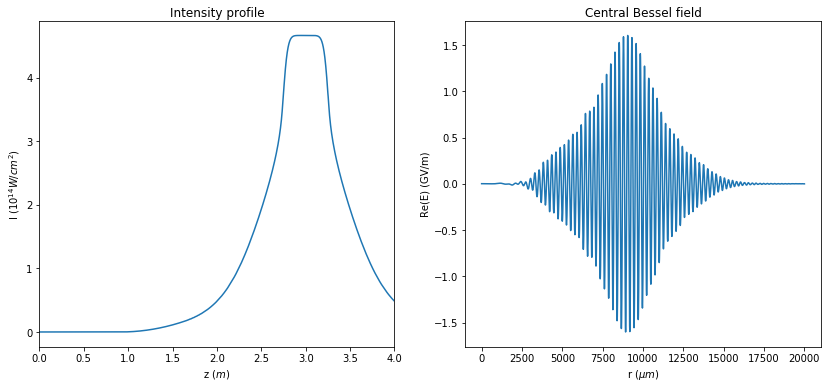

In [4]:
# Create the input field for the central mode with the ramps
params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 100,
    'lam' : lam
}
rJ0, EJ0 = bessel.bessel_expansion(params, z, I)
plt.subplot(122)
plt.plot(rJ0, EJ0.real)
plt.title('Central Bessel field')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel('Re(E) (GV/m)')
plt.show()

In [5]:
def plot_longitudinal(beam):
    print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                         beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
    N = 100
    z = np.linspace(0, 2.0e6, N)
    beam.propagate(z, 1.0)
    e = np.zeros((N, beamNx), dtype='complex128')
    for i in range(N):
        e[i, :] = beam.load_field(i+1)[0]

    lonn = adk.gaussian_frac(ionization.Ar['EI'], abs(e), tau, ionization.Ar['Z'], ionization.Ar['l'])
    lonn = beam.prep_data(lonn)
    lonI = beam.intensity_from_field(e)
    lonI = beam.prep_data(lonI)

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(lonI, aspect='auto', extent=[0, 2e6, -beamX/2, beamX/2])
    cb = plt.colorbar()
    cb.set_label(r'Intensity')
    plt.set_cmap('viridis')
    plt.xlabel(r'z')
    plt.ylabel(r'x')
    plt.ylim([-1000, 1000])
    plt.title('Longitudinal intensity')
    
    plt.subplot(122)
    plt.imshow(lonn, aspect='auto', extent=[0, 2e6, -beamX/2, beamX/2])
    cb = plt.colorbar()
    cb.set_label(r'Ionization fraction')
    plt.set_cmap('plasma')
    plt.xlabel(r'z')
    plt.ylabel(r'x')
    plt.ylim([-1000, 1000])
    plt.title('Longitudinal plasma density')
    plt.tight_layout()
    plt.show()

Power: 1.05541814841


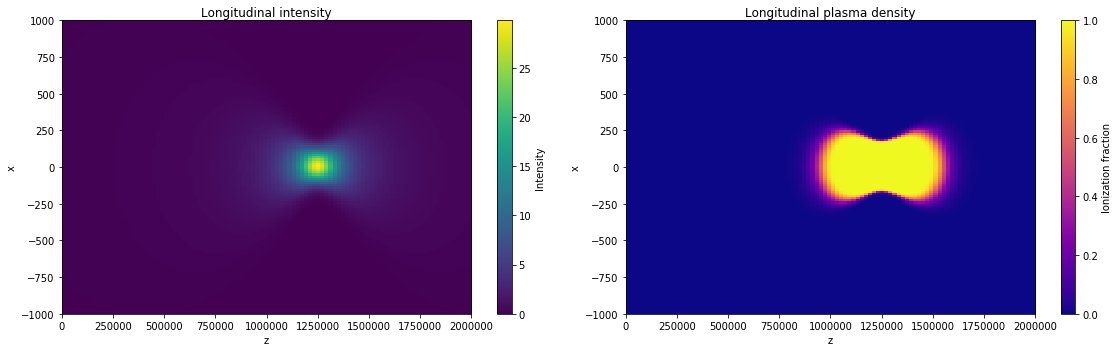

Power: 1.87629892403


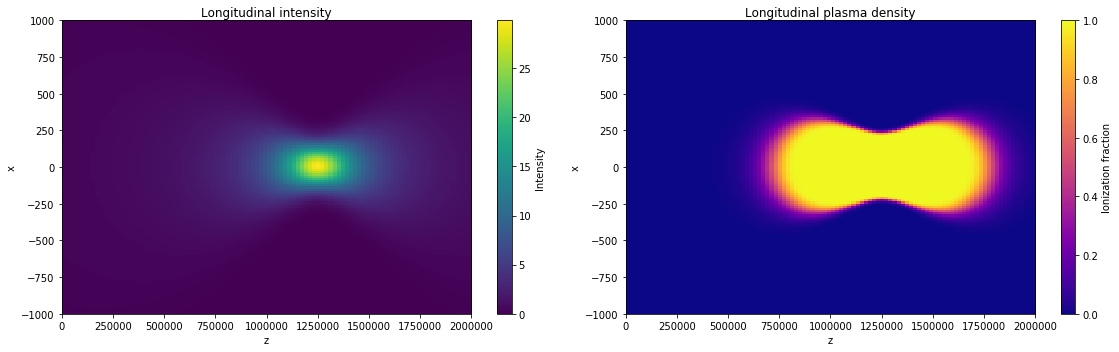

Power: 2.93171704883


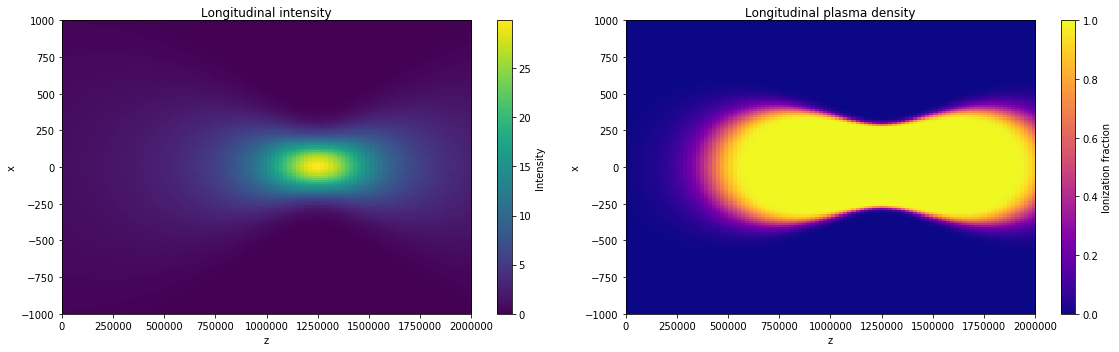

Power: 1.8762989305


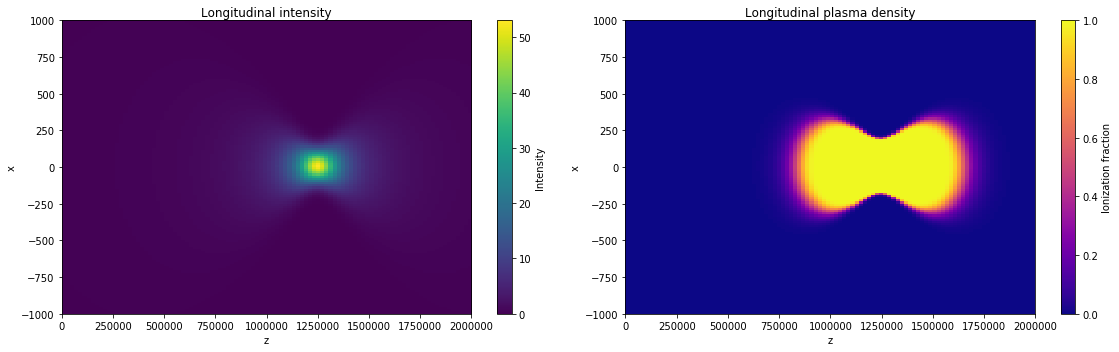

Power: 3.33564253161


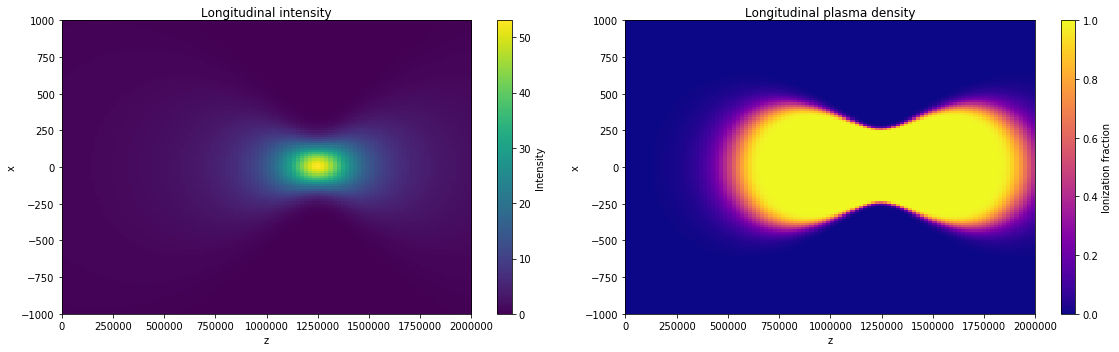

Power: 5.21194142014


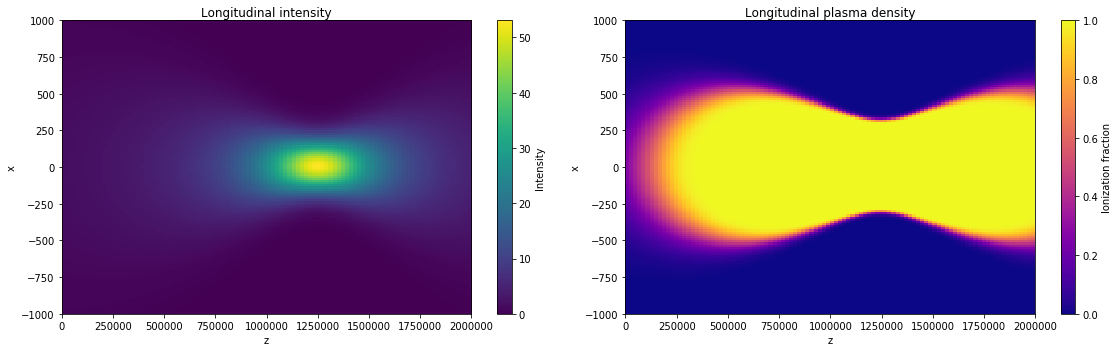

Power: 2.93171707891


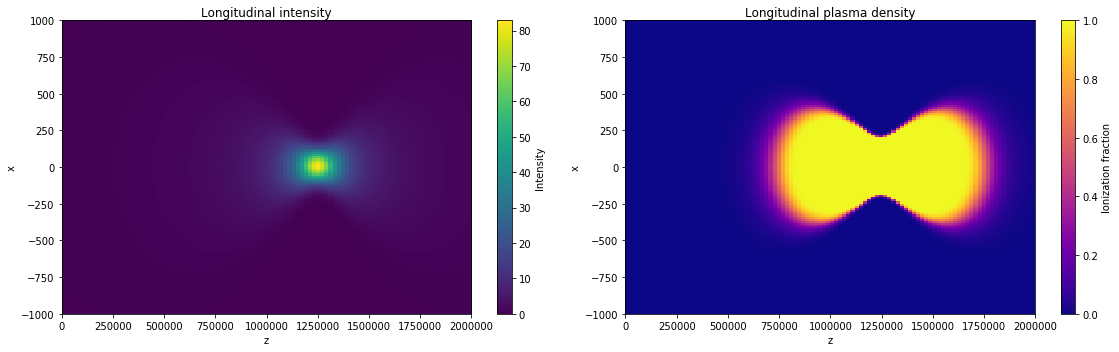

Power: 5.21194145563


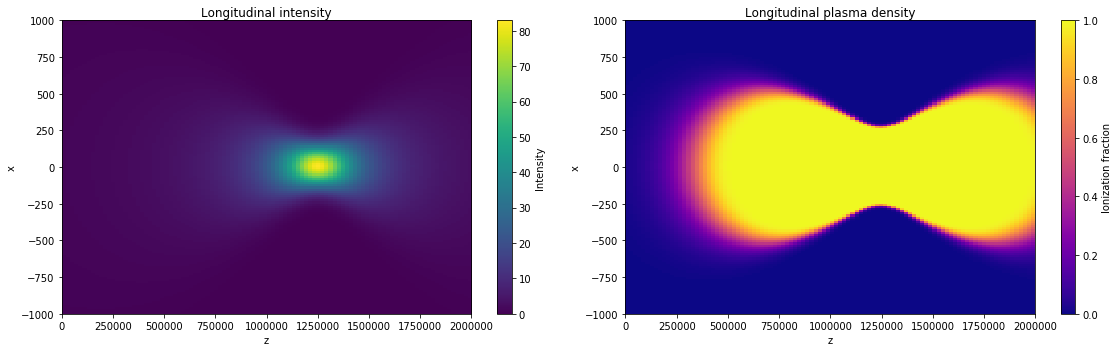

Power: 8.14365846897


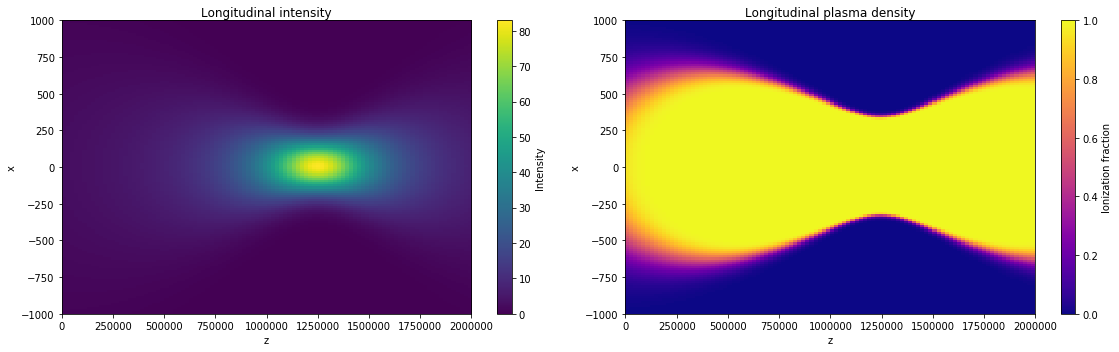

Power: 4.22167259363


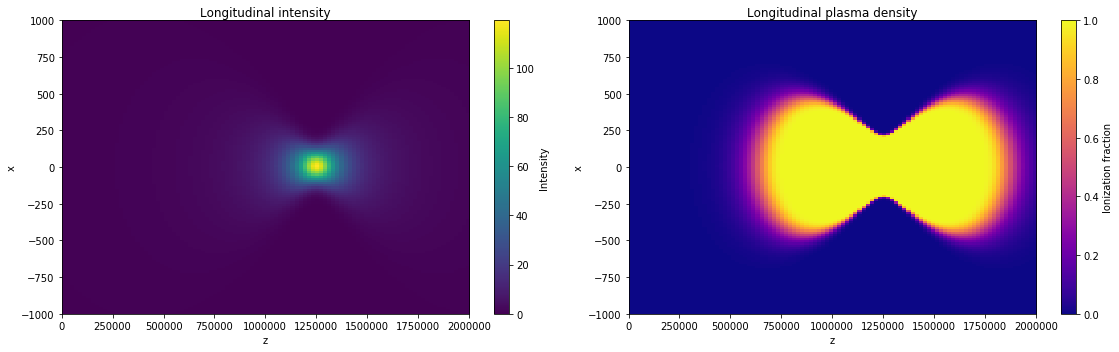

Power: 7.50519569611


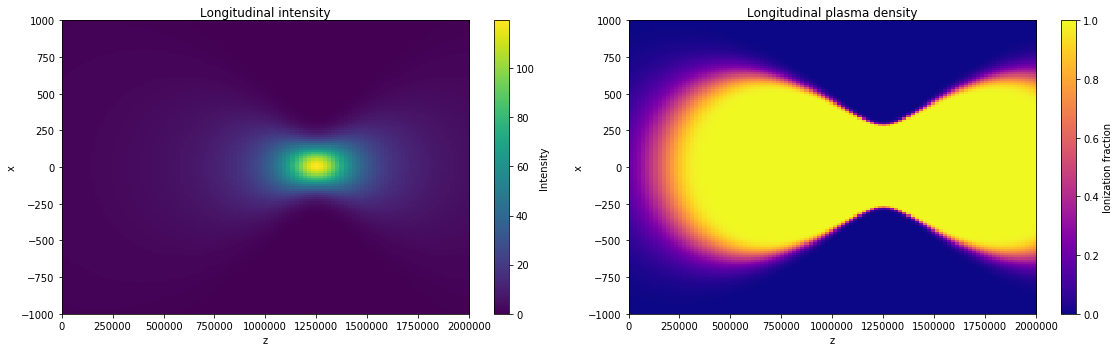

Power: 11.7268681953


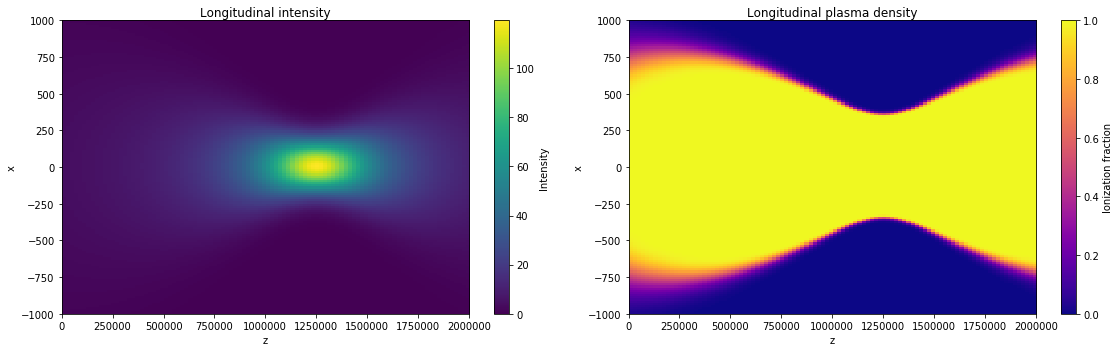

In [6]:
# Calculate the plasma density for the unrefracted spherical lenses
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['z0'] = -1.25e6
E0 = [150., 200., 250., 300.]
waist = [150., 200., 250.]
for i in range(len(E0)):
    for j in range(len(waist)):
        pulseParams['name'] = 'E0-%3.0f_waist-%3.0f_SBeam' % (E0[i], waist[j])
        pulseParams['E0'] = E0[i]
        pulseParams['waist'] = waist[j]
        beam = laserbeam.GaussianLaser(pulseParams)
        plot_longitudinal(beam)

Power: 0.6307609215


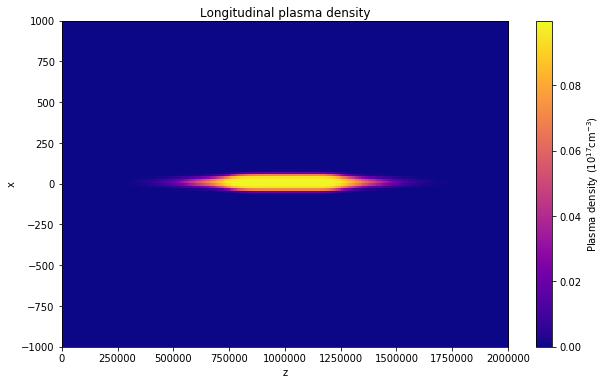

In [7]:
# Calculate the plasma density for the central mode
multiJ0 = 1.0
pulseParams['name'] = 'J0Beam'
pulseParams['order'] = 0
pulseParams['Nx'] = beamNx
pulseParams['Ny'] = beamNy
pulseParams['X'] = beamX
pulseParams['Y'] = beamY
pulseParams['r'] = rJ0
pulseParams['E'] = multiJ0 * EJ0
beam = laserbeam.RadialLaser(pulseParams)
print('Power:', beam.total_cyl_power(beam.x[int(beam.Nx/2):],
                                     beam.intensity_from_field(beam.e[int(beam.Nx/2):, int(beam.Ny/2)])))
beam.propagate(2.0e6, 1.0) # propagate to the start of the plasma
pulseParams['name'] = 'J0Pulse'
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['r'] = beam.x
pulseParams['E'] = beam.e[:, int(beam.Ny/2)]
pulse = laserpulse.RadialPulse(pulseParams)
plasmaParams['name'] = 'Plasma0'
argon = plasma.UniformPlasma(plasmaParams)
interactions.pulse_plasma(pulse, argon)
argon.plot_long_density_center(lim=[-1000, 1000])

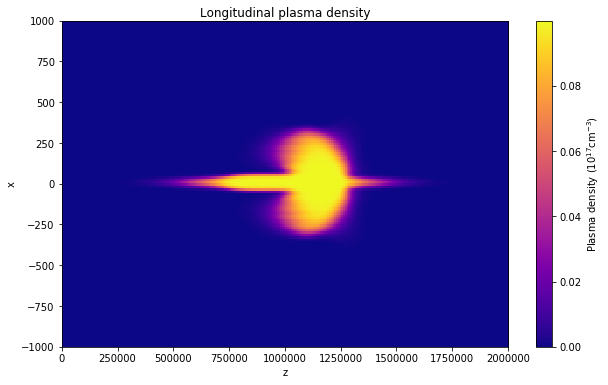

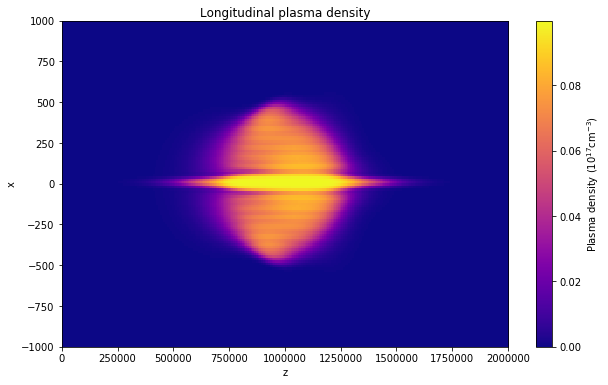

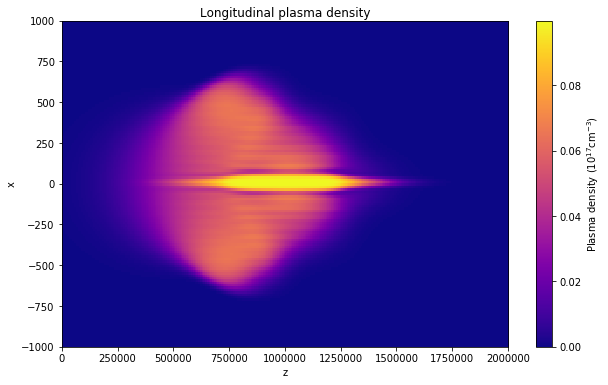

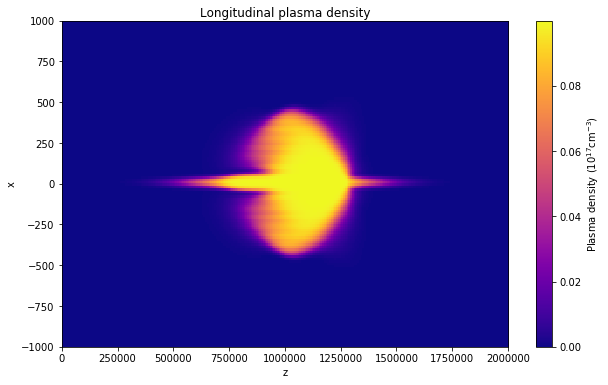

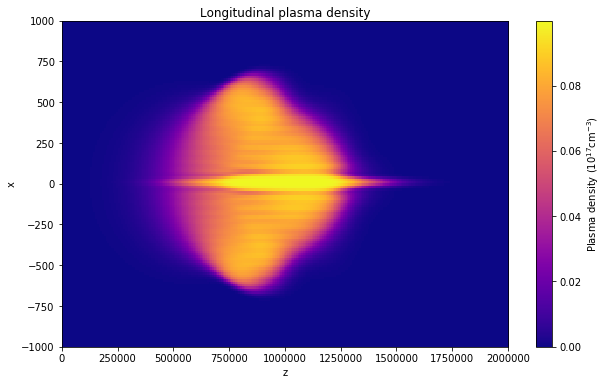

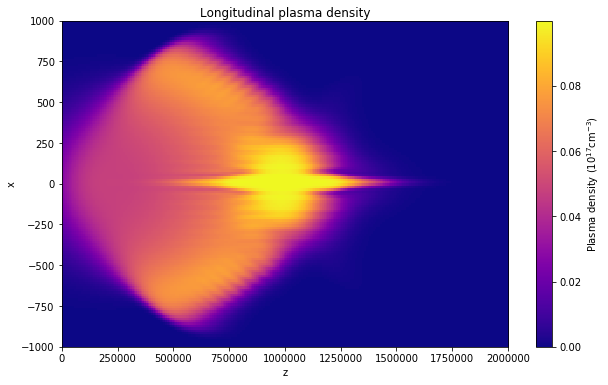

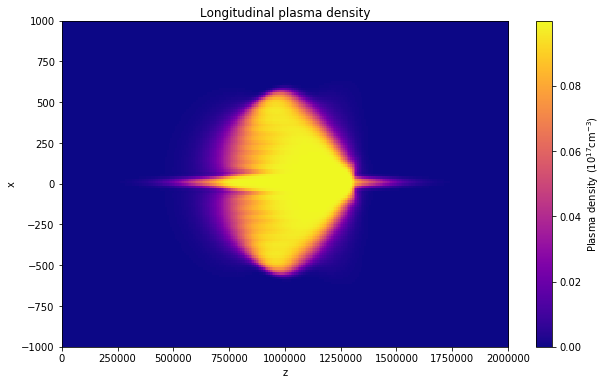

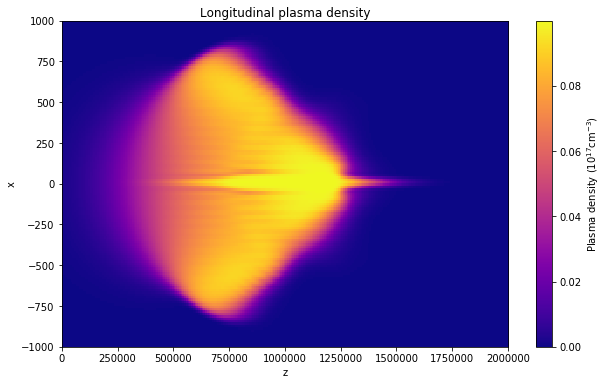

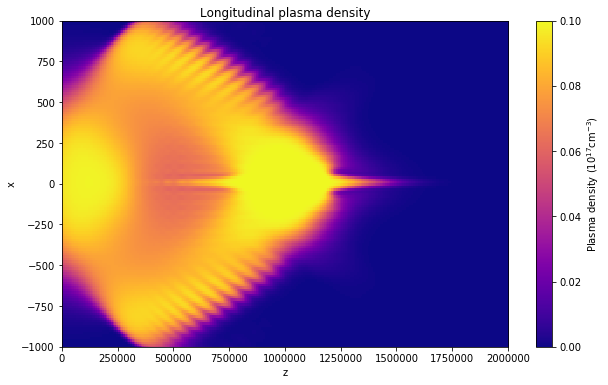

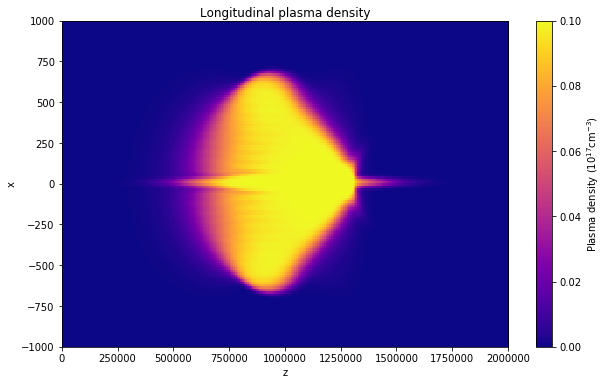

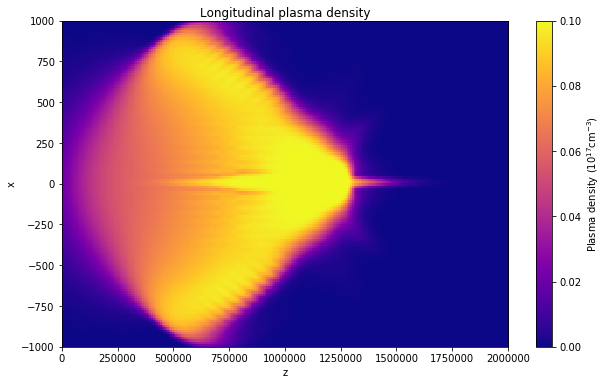

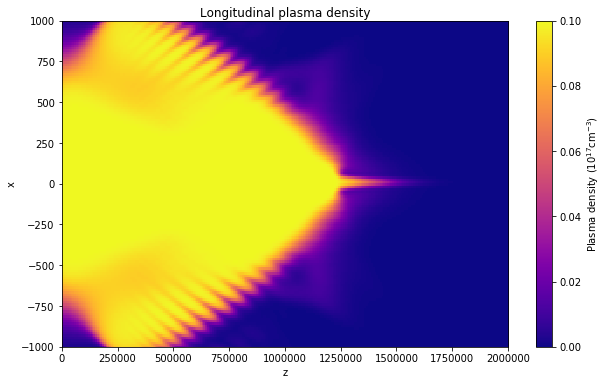

In [8]:
# Calculate the plasma density for the spherical modes
pulseParams['Nx'] = pulseNx
pulseParams['Ny'] = pulseNy
pulseParams['X'] = pulseX
pulseParams['Y'] = pulseY
pulseParams['z0'] = -1.25e6
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = 'Plasma0'
for i in range(len(E0)):
    for j in range(len(waist)):
        pulseParams['name'] = 'E0-%3.0f_waist-%3.0f_SPulse' % (E0[i], waist[j])
        pulseParams['E0'] = E0[i]
        pulseParams['waist'] = waist[j]
        pulse = laserpulse.GaussianPulse(pulseParams)
        plasmaParams['name'] = 'E0-%3.0f_waist-%3.0f_SPlasma' % (E0[i], waist[j])
        argon = plasma.ExistingPlasma(plasmaParams)
        interactions.pulse_plasma(pulse, argon)
        argon.plot_long_density_center(lim=[-1000, 1000])